In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Build first baseline model

In [7]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/workspace/Data-Science/mobility-285808-aa8e44818175.json'

# import GCP Client library
from google.cloud import bigquery

#instantiate a client for bigquery service
bigquery_client = bigquery.Client()
bigquery_client

In [8]:
base_query="""
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour
"""

In [9]:
# run query and get data from bigquery
query_job = bigquery_client.query(base_query) #API request

# data into dataframe
df = query_job.to_dataframe()
df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10454,2015-01-01,1,1,3,0,0,8
1,10167,2015-01-01,1,1,3,0,0,18
2,10153,2015-01-01,1,1,3,0,0,30
3,11372,2015-01-01,1,1,3,0,0,25
4,11217,2015-01-01,1,1,3,0,0,121


In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['zip_code']])
one_output = enc.transform(df[['zip_code']]).toarray()
ohe_df = pd.concat([df, pd.DataFrame(one_output, columns='zip_code_' + enc.categories_[0])], axis=1)
ohe_df.head(3)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,zip_code_10001,zip_code_10002,...,zip_code_12601,zip_code_12729,zip_code_12771,zip_code_13029,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801
0,10454,2015-01-01,1,1,3,0,0,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10167,2015-01-01,1,1,3,0,0,18,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10153,2015-01-01,1,1,3,0,0,30,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# df = time series dataframe
# date = standard point
def split_train_and_test(df, date):
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Linear Regression

In [17]:
df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,10454,2015-01-01,1,1,3,0,0,8
1,10167,2015-01-01,1,1,3,0,0,18
2,10153,2015-01-01,1,1,3,0,0,30
3,11372,2015-01-01,1,1,3,0,0,25
4,11217,2015-01-01,1,1,3,0,0,121


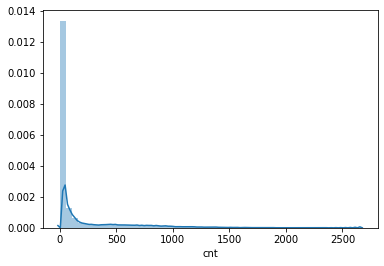

In [16]:
#Overall distribution
sns.distplot(ohe_df ['cnt'])

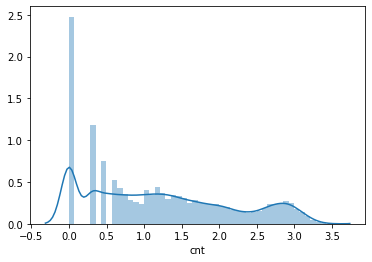

In [18]:
#Overall distribution in log 
sns.distplot(np.log10(df['cnt']))